In [3]:
import os
import sys
import torch
import templateflow
import nilearn
import nilearn.datasets
import nilearn.connectome
import nilearn.input_data
sys.path.append(os.path.join(".."))
import gcn_package
import gcn_package.data.raw_data_loader
import gcn_package.data.time_windows_dataset
import gcn_package.features.graph_construction
import gcn_package.models.gcn
import gcn_package.visualization.visualize

print("torch v{}".format(torch.__version__))
print("nilearn v{}".format(nilearn.__version__))
print("gcn_package v{}".format(gcn_package.__version__))

torch v1.8.0
nilearn v0.8.0
gcn_package v0.1.0


# Initial parameters

In [4]:
# parameters
num_parcels = 512 # number of parcels (nodes) to keep for the graph
window_length = 50 #number of timepoints per sample (timeserie)
zero_padding = True #pad splitted timeseries with zeros, or remove incomplete
random_seed = 0 # fix random state for dat ageneration, and pytorch fit
# paths
model_path = os.path.join("..", "models", "gcn_test.pt")
raw_dir = os.path.join("..", "data", "raw")
data_dir = os.path.join("..", "data", "processed", f"cobre_difumo{num_parcels}")
ts_out = os.path.join(data_dir, "timeseries")
conn_out = os.path.join(data_dir, "connectomes")

if not os.path.exists(ts_out):
    os.makedirs(ts_out)
if not os.path.exists(conn_out):
    os.makedirs(conn_out)

# Dataset fetching and connectomes generation

In [5]:

#TODO: replace with templateflow when difumo is working
# Fetching atlas
atlas = nilearn.datasets.fetch_atlas_difumo(data_dir=raw_dir, dimension=num_parcels)
atlas_filename = atlas['maps']
atlas_labels = atlas['labels']

# Fetching data
data = nilearn.datasets.fetch_cobre(data_dir=raw_dir, n_subjects=None) #all subs

/home/ltetrel/.local/lib/python3.6/site-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)
/home/ltetrel/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function fetch_cobre is deprecated; 'fetch_cobre' has been deprecated and will be removed in release 0.9 . Please consider using a different datasets or downloading it with a different tool than nilearn.
  warnings.warn(msg, category=DeprecationWarning)


In [6]:
# Estimating connectomes
# import numpy as np

# masker = nil.input_data.NiftiMapsMasker(maps_img=atlas['maps'], standardize=True, verbose=5)
# corr_measure = nil.connectome.ConnectivityMeasure(kind="correlation")

# for i in range(len(data.func)):
#     ts = masker.fit_transform(data.func[i], confounds=data.confounds[i])
#     conn = corr_measure.fit_transform([ts])[0]
#     sub_num = os.path.basename(data.func[i]).split('.')[0].split('_')[1]
#     np.save(os.path.join(ts_out, "timeseries_{}_difumo_{}.npy".format(sub_num, num_parcels)), ts)
#     np.save(os.path.join(conn_out, "conn_{}_difumo_{}.npy".format(sub_num, num_parcels)), conn)
#     print("Done {}/146".format(i+1))

# Data generator

In [7]:
# Preparing data for generator
# this include timeseries loading, splitting and labeling
pheno_path = os.path.join(raw_dir, "cobre", "phenotypic_data.tsv")
split_dir = os.path.join("..", "data", "interim")

In [8]:
# remove previous content
if os.path.exists(split_dir):
    import glob

    files = glob.glob(os.path.join(split_dir, "[^.gitkeep]*"))
    for f in files:
        os.remove(f)

In [9]:
RawDataLoad = gcn_package.data.raw_data_loader.RawDataLoader(
    num_nodes = num_parcels
    , ts_dir=ts_out
    , conn_dir=conn_out
    , pheno_path=pheno_path)
RawDataLoad.split_timeseries_and_save(window_length=window_length, zero_padding=zero_padding, output_dir=split_dir)

../gcn_package/data/raw_data_loader.py:103: UserWarning: Different shapes for sub ID(s): ['40075']
  warnings.warn("Different shapes for sub ID(s): {}".format(non_valid_ids))


In [10]:
RawDataLoad.get_valid_timeseries()[0].shape

(150, 512)

In [11]:
# Pytorch dataset: generates items from the current data directory
train_dataset = gcn_package.data.time_windows_dataset.TimeWindowsDataset(
    data_dir=split_dir
    , partition="train"
    , random_seed=random_seed
    , pin_memory=True
    , normalize=True)
valid_dataset = gcn_package.data.time_windows_dataset.TimeWindowsDataset(
    data_dir=split_dir
    , partition="valid"
    , random_seed=random_seed
    , pin_memory=True
    , normalize=True)
test_dataset = gcn_package.data.time_windows_dataset.TimeWindowsDataset(
    data_dir=split_dir
    , partition="test"
    , random_seed=random_seed
    , pin_memory=True
    , normalize=True)
print("train dataset: {}".format(train_dataset))
print("valid dataset: {}".format(valid_dataset))
print("test dataset: {}".format(test_dataset))

train dataset: 304*(torch.Size([512, 50]), ())
valid dataset: 87*(torch.Size([512, 50]), ())
test dataset: 44*(torch.Size([512, 50]), ())


In [12]:
# Pytorch dataloader: wraps an iterable around the pytorch dataset to shuffle and generate (in parrallel) minibatches
#setting pytoch seed for reproducible torch.utils.data.DataLoader
torch.manual_seed(random_seed)
train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_generator = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=True)
test_generator = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)
train_features, train_labels = next(iter(train_generator))
print(f"Feature batch shape: {train_features.size()}; mean {torch.mean(train_features)}")
print(f"Labels batch shape: {train_labels.size()}; mean {torch.mean(torch.Tensor.float(train_labels))}")

Feature batch shape: torch.Size([16, 512, 50]); mean 1.210719302591201e-09
Labels batch shape: torch.Size([16]); mean 0.5625


In [28]:
next(iter(train_generator))[0].shape

torch.Size([16, 512, 50])

# Model definition

In [14]:
# model definition
# get average connectome with its k-nearest neighbors
connectomes = RawDataLoad.get_valid_connectomes()
graph = gcn_package.features.graph_construction.make_group_graph(connectomes, k=8, self_loops=False, symmetric=True)
# Create model
gcn = gcn_package.models.gcn.CustomGCN(graph.edge_index, graph.edge_attr, n_timepoints=window_length, n_roi=num_parcels, n_classes=2)
gcn

CustomGCN()

In [15]:
graph.edge_index

tensor([[  0,   0,   0,  ..., 511, 511, 511],
        [  6,  74, 137,  ..., 319, 432, 499]])

In [21]:
graph

Data(edge_attr=[5378], edge_index=[2, 5378])

In [20]:
list(gcn.parameters())
gcn2 = gcn_package.models.gcn.YuGCN(graph.edge_index, graph.edge_attr, n_timepoints=window_length, n_roi=num_parcels, n_classes=2)
list(gcn2.parameters())


[Parameter containing:
 tensor([[[ 0.1152,  0.1071, -0.0341,  ...,  0.2043,  0.2704,  0.2365],
          [ 0.2096, -0.0620, -0.0949,  ..., -0.1846, -0.0437, -0.1757],
          [ 0.1878, -0.2045, -0.1320,  ...,  0.1730,  0.0201, -0.1277],
          ...,
          [ 0.1381,  0.1357,  0.1913,  ..., -0.1225, -0.1070, -0.0349],
          [ 0.0296, -0.1887, -0.2166,  ..., -0.0887,  0.0907,  0.0754],
          [-0.1578,  0.0262, -0.2054,  ...,  0.0344, -0.1382, -0.0242]],
 
         [[-0.0338, -0.2556,  0.1834,  ...,  0.1140,  0.1131, -0.2335],
          [-0.2378, -0.2097,  0.0047,  ..., -0.2118, -0.1561, -0.2464],
          [-0.0545,  0.1088, -0.2053,  ...,  0.1500,  0.0485,  0.0413],
          ...,
          [ 0.1369, -0.0086,  0.2606,  ...,  0.1951,  0.2326, -0.0989],
          [-0.1325,  0.0453,  0.1456,  ..., -0.0778, -0.1383, -0.0601],
          [-0.1146,  0.0087, -0.1953,  ..., -0.2314,  0.1298, -0.0610]]],
        requires_grad=True), Parameter containing:
 tensor([0., 0., 0., 0., 0.

# Training

In [16]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), batch * dataloader.batch_size
        correct = (pred.argmax(dim=1) == y).type(torch.float).sum().item()
        correct /= X.shape[0]
        print(f"#{batch:<2}\t\ttrain_loss: {loss:>0.3f};\ttrain_accuracy: {(100*correct):>5.1f}%\t\t[{current:>5d}/{size:>5d}]")

def valid_test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model.forward(X)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(dim=1) == y).type(torch.float).sum().item()

    loss /= size
    correct /= size

    return loss, correct

In [17]:
# Train and evaluate the model
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gcn.parameters(), lr=1e-4, weight_decay=5e-4)

epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}\n-------------------------------")
    train_loop(train_generator, gcn, loss_fn, optimizer)
    loss, correct = valid_test_loop(valid_generator, gcn, loss_fn)
    print(f"Valid metrics:\n\t avg_loss: {loss:>8f};\t avg_accuracy: {(100*correct):>0.1f}%")
print("Done!")

ValueError: optimizer got an empty parameter list

# Test

In [13]:
loss, correct = valid_test_loop(test_generator, gcn, loss_fn)
print(f"Test metrics:\n\t avg_loss: {loss:>8f};\t avg_accuracy: {(100*correct):>0.1f}%")

Test metrics:
	 avg_loss: 0.057387;	 avg_accuracy: 45.5%


In [14]:
for X, y in test_generator:
    print(X.shape)
    print(y.shape)
    print(type(X[0]))
    print(type(y[0]))

torch.Size([16, 512, 50])
torch.Size([16])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([16, 512, 50])
torch.Size([16])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([12, 512, 50])
torch.Size([12])
<class 'torch.Tensor'>
<class 'torch.Tensor'>


# Model saving

In [16]:
torch.save(gcn.state_dict(), model_path)

# PCA visualization

/home/ltetrel/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


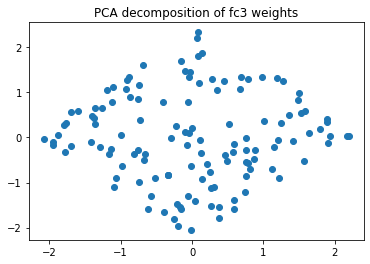

In [17]:
gcn_package.visualization.visualize.vizualize_weights(gcn, "fc3")

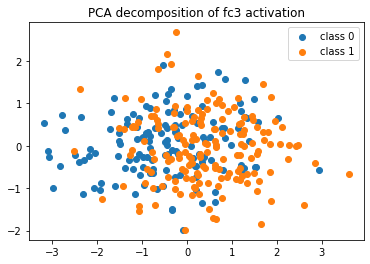

In [18]:
gcn_package.visualization.visualize.visualize_activation(gcn, train_generator, "fc3")